### Noise calculations for paper revisions


This notebook explores the model training noise as requested during the first round of paper review.

We use the conda environment `analysis`


#### Define some useful functions

In [131]:
import pandas as pd 
import glob as glob 
import random 
import numpy as np 

import warnings
warnings.filterwarnings("ignore") #ignore FutureWarning statements
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/'




def collect_noise_numbers(file_id):
    
    models = sorted(glob.glob(f'{root}{file_id}_noise_expt_*'))
    
    print("Collecting noise numbers for the following files:")
    dfs = []
    for m in models:
        print(m)
        df = pd.read_parquet(m+'/predictions.parquet')
        dfs.extend([df])
        
        
    #Merging manually - must be a way to auto this, but my joins keep failing
    
    #Some checks - due to manual merging 
    assert np.all(dfs[0].latitude_ERA == dfs[1].latitude_ERA)
    assert np.all(dfs[1].latitude_ERA == dfs[2].latitude_ERA)
    assert np.all(dfs[2].latitude_ERA == dfs[3].latitude_ERA)
    
    assert np.all(dfs[0].longitude_ERA == dfs[1].longitude_ERA)
    assert np.all(dfs[1].longitude_ERA == dfs[2].longitude_ERA)
    assert np.all(dfs[2].longitude_ERA == dfs[3].longitude_ERA)
    
    assert np.all(dfs[0].MODIS_LST == dfs[1].MODIS_LST)
    assert np.all(dfs[1].MODIS_LST == dfs[2].MODIS_LST)
    assert np.all(dfs[2].MODIS_LST == dfs[3].MODIS_LST)
    
    assert np.all(dfs[0].time == dfs[1].time)
    assert np.all(dfs[1].time == dfs[2].time)
    assert np.all(dfs[2].time == dfs[3].time)
    
    
  

    
    data = { 'latitude_ERA':     dfs[0].latitude_ERA, 
             'longitude_ERA':    dfs[0].longitude_ERA,
             'MODIS_LST':        dfs[0].MODIS_LST,
             'time':             dfs[0].time,
            'prediction_0':      dfs[0].predictions,
            'prediction_1':      dfs[1].predictions,
            'prediction_2':      dfs[2].predictions,
            'prediction_3':      dfs[3].predictions,
          }
    

    df = pd.DataFrame(data)  
    
    
    #Get the mean prediction and the variance 
    cols = [f'prediction_{i}' for i in range(4)]
    df["prediction_mean"]=df[cols].mean(axis=1) 
    df["prediction_variance"]=df[cols].var(axis=1) 
    
    
    #Now get the model error, with variance
    df["prediction_error"] = abs(df.MODIS_LST - df.prediction_mean) #the uncertainty in this is the same as df["prediction_variance"]
    
    #Create some extra time category columns which we can group over
    df['year'] = pd.DatetimeIndex(df.time).year #all 2019
    df['month'] = pd.DatetimeIndex(df.time).month
    df['day'] = pd.DatetimeIndex(df.time).date
    
    
    
    
    
    return df 
    
    #std: https://stats.stackexchange.com/questions/25848/how-to-sum-a-standard-deviation
    

        
#     #Get the mean and variance
#     prediction_cols = [f"prediction_{i}" for i in range(4)]
   

#     selected_cols      = [prediction_cols,prediction_bias_cols,prediction_error_cols]
#     selected_col_names = ["prediction", "bias", "error"]
#     for i in range(len(selected_cols)):

#         c = selected_cols[i]
#         name = selected_col_names[i]
#         print(c,name)


 

#     return df[['latitude_ERA','longitude_ERA','time','year','month','day','MODIS_LST','prediction_mean','prediction_variance']] 
    
    
    
    
    
    
def get_annual_averages(df):
    
    #Average over the year
    #Uncertainties are handled via: https://stats.stackexchange.com/questions/25848/how-to-sum-a-standard-deviation
    df_annual = df.groupby(['latitude_ERA', 'longitude_ERA','year'],as_index=False).mean() 
    df_annual["prediction_std"] = np.sqrt(df_annual['prediction_variance'])
    
    
    
    change_in_fields = pd.read_pickle('tmp_data/change_in_fields.pkl')
    change_in_fields['latitude_join'] = round(change_in_fields.latitude_ERA,3)
    change_in_fields['longitude_join'] = round(change_in_fields.longitude_ERA,3) #just used for joining due to loss of precision from Margs file
    
    df_annual['latitude_join']=round(df_annual.latitude_ERA,3)
    df_annual['longitude_join']=round(df_annual.longitude_ERA,3)
    
    
    #Join and save
    df_annual_categorised = pd.merge(df_annual,change_in_fields,how='inner',on=['latitude_join', 'longitude_join'],suffixes=('', '_y')) #inner join.
    df_annual_categorised = df_annual_categorised.drop(['latitude_join', 'longitude_join','latitude_ERA_y', 'longitude_ERA_y'], axis=1) #Get rid of junk columns
    
    return df_annual_categorised


In [132]:
dfV15 = collect_noise_numbers("V15")
dfV20 = collect_noise_numbers("V20")

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V15_noise_expt_1
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V15_noise_expt_2
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V15_noise_expt_3
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V15_noise_expt_4
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V20_noise_expt_1
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V20_noise_expt_2
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V20_noise_expt_3
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V20_noise_expt_4


#### Categorise the points

In [134]:
change_in_fields = pd.read_pickle('tmp_data/change_in_fields.pkl')
change_in_fields['latitude_join'] = round(change_in_fields.latitude_ERA,3)
change_in_fields['longitude_join'] = round(change_in_fields.longitude_ERA,3) #just used for joining due to loss of precision from Margs file

In [137]:

dfV15['latitude_join']=round(dfV15.latitude_ERA,3)
dfV15['longitude_join']=round(dfV15.longitude_ERA,3)


blob  = pd.merge(dfV15,change_in_fields,how='inner',on=['latitude_join', 'longitude_join'],suffixes=('', '_y')) #inner join.


In [148]:
df_veg = blob.query('cvhFr_change_is_significant & not clFr_change_is_significant')

In [149]:
df_veg_daily = df_veg.groupby(['latitude_ERA', 'longitude_ERA','day'],as_index=False).mean() 


In [152]:
selected_lat = df_veg_daily.latitude_ERA[0]
selected_lon = df_veg_daily.longitude_ERA[1]

df_veg_daily_x = df_veg_daily.query(f'latitude_ERA == {selected_lat} & longitude_ERA == {selected_lon}')

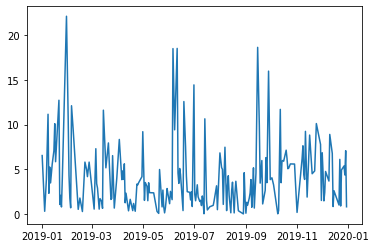

In [154]:
import matplotlib.pyplot as plt 


plt.plot(df_veg_daily_x['day'],df_veg_daily_x['prediction_error'])



#### Average over the year and categorise the grid points

In [122]:
dfV15_annual = get_annual_averages(dfV15)
dfV20_annual = get_annual_averages(dfV20)

#### LAKES

In [129]:
pd.options.mode.chained_assignment = None #Ignore SettingWithCopyWarning - we are safe here
import matplotlib.pyplot as plt
def surface_noise_numbers(df1,df2):
    
    mean_prediction_error_1 = df1['prediction_error'].mean()
    mean_prediction_error_std_1 = np.sqrt(df1['prediction_variance'].mean())
    
        
    mean_prediction_error_2 = df2['prediction_error'].mean()
    mean_prediction_error_std_2 = np.sqrt(df2['prediction_variance'].mean())
    
    
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
    df1['prediction_error'].hist(bins=100,ax=ax,label='df1')
    df2['prediction_error'].hist(bins=100,ax=ax,label='df2')
    plt.show()



    print(mean_prediction_error_1,mean_prediction_error_std_1)
    print(mean_prediction_error_2,mean_prediction_error_std_2)

    


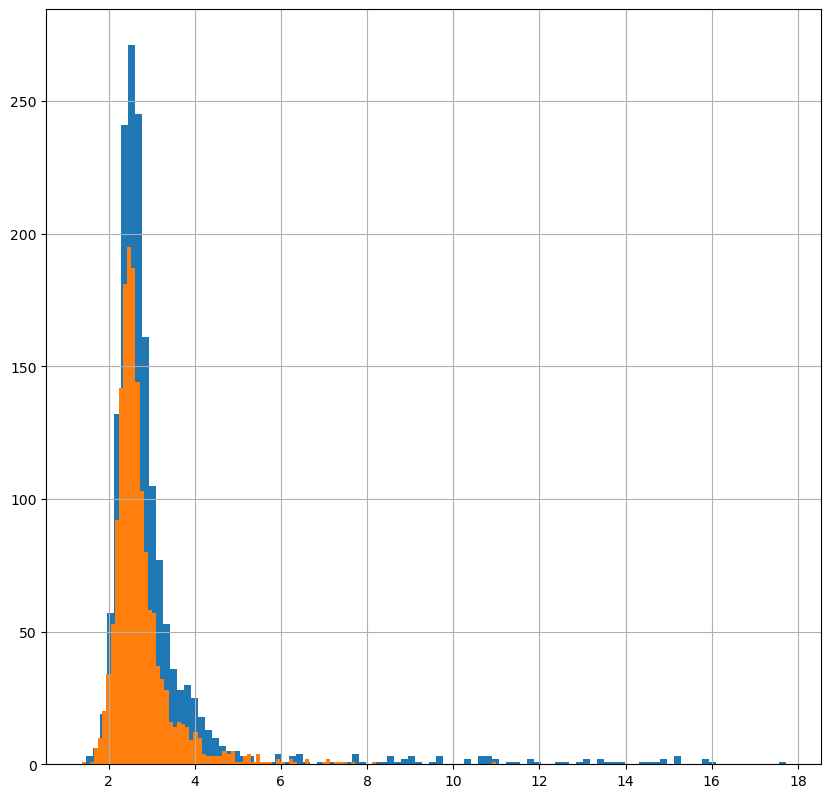

3.127006 0.97818387
2.745074 0.9978645


In [130]:
lake_condition = 'clFr_change_is_significant & dl_change_is_significant & not oceanFr_change_is_significant & not si10Fr_change_is_significant'
df_lake1 = dfV15_annual.query(lake_condition)
df_lake2 = dfV20_annual.query(lake_condition)

surface_noise_numbers(df_lake1,df_lake2)

Numer of grid points: 1631
Mean prediction error: 2.9956074
Mean prediction bias: 0.09965725
Mean variance in the error: 6.026490688323975
Mean variance in the bias: 14.301363945007324


Numer of grid points: 1631
Median variance: 0.008567211218178272
Mean variance: 0.18161985
Median median error: 2.7064685821533203
Mean mean error: 3.1902435


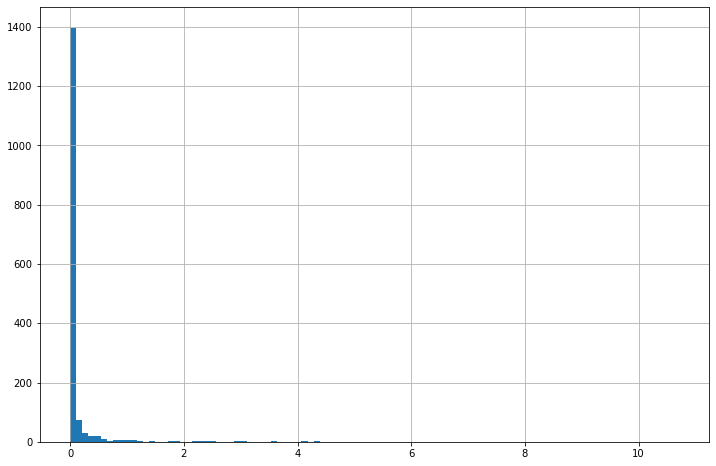

In [204]:
df_lake = df_cat.query('clFr_change_is_significant & dl_change_is_significant & not oceanFr_change_is_significant & not si10Fr_change_is_significant')
surface_noise_numbers(df_lake)

In [205]:
df_lake

,latitude_ERA,longitude_ERA,MODIS_LST,prediction_error_1,prediction_1,prediction_error_2,prediction_2,prediction_error_3,prediction_3,prediction_error_4,...,cvhFr_change_is_significant,cvlFr_change_is_significant,oceanFr_change_is_significant,si10Fr_change_is_significant,dl_change_is_significant,z_change_is_significant,bitstring,variance,median_error,mean_error
2298,-54.379367,-68.906250,278.404236,2.932979,276.383575,2.512748,277.031494,2.310007,277.640930,2.243198,...,False,False,False,False,True,False,1001000,0.096559,2.411377,2.499733
2524,-51.007004,-73.750000,274.123169,4.816545,275.111725,5.288032,275.785950,5.167870,274.520111,4.902350,...,False,False,False,False,True,False,1001000,0.048898,5.035110,5.043699
2640,-49.320823,-74.583333,279.504425,4.760699,275.700714,4.083141,276.669220,4.616580,275.989258,3.996458,...,False,False,False,False,True,False,1001000,0.145045,4.349860,4.364219
2693,-48.758762,-74.000000,275.387543,3.436432,276.164429,3.838189,276.796082,3.646682,275.872101,3.621224,...,False,True,False,False,True,False,1011000,0.027013,3.633953,3.635632
2762,-48.196702,-66.400000,292.468079,2.923074,292.568604,3.029530,292.389893,3.116231,291.987213,3.274108,...,False,False,False,False,True,False,1001000,0.022011,3.072881,3.085736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149748,70.117048,130.500000,261.509766,3.839574,261.287903,3.760233,260.972443,3.424365,261.413513,3.878855,...,False,True,False,False,True,False,1011000,0.042806,3.799904,3.725757
149769,70.117048,146.250000,259.166626,2.950216,260.663452,2.999373,260.977509,2.793789,260.426605,2.807885,...,False,True,False,False,True,False,1011000,0.010523,2.879051,2.887816
149770,70.117048,147.000000,259.823456,2.921776,261.298187,3.033228,261.639099,2.826963,260.957520,2.843283,...,False,True,False,False,True,False,1011000,0.008872,2.882529,2.906312
149780,70.117048,154.500000,260.750122,3.073905,262.178558,3.093780,262.130035,3.051725,261.953247,3.153682,...,False,True,False,False,True,False,1011000,0.001917,3.083842,3.093273


#### Lake ground

In [206]:
df_lake_ground = df_cat.query('clFr_change_is_significant & dl_change_is_significant & not oceanFr_change_is_significant & not cvhFr_change_is_significant & not cvlFr_change_is_significant')


Numer of grid points: 546
Median variance: 0.02431214600801468
Mean variance: 0.41963476
Median median error: 2.9327445030212402
Mean mean error: 3.953188


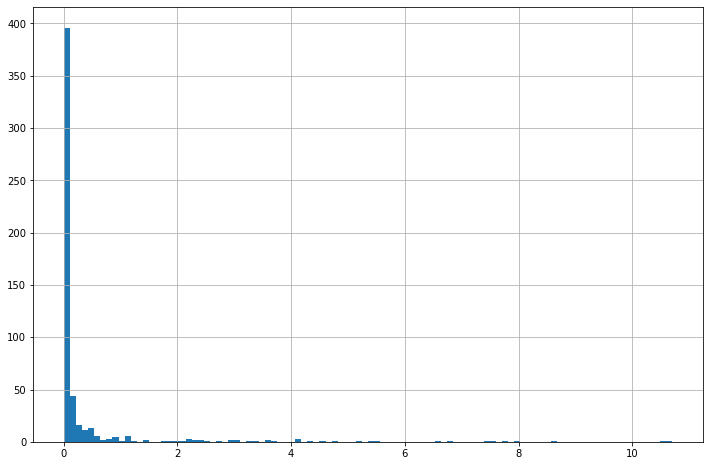

In [207]:
surface_noise_numbers(df_lake_ground)

#### Vegetation

In [208]:
df_vegetation = df_cat.query('cvhFr_change_is_significant & not clFr_change_is_significant')


In [214]:
df_vegetation

,latitude_ERA,longitude_ERA,MODIS_LST,prediction_error_1,prediction_1,prediction_error_2,prediction_2,prediction_error_3,prediction_3,prediction_error_4,...,cvhFr_change_is_significant,cvlFr_change_is_significant,oceanFr_change_is_significant,si10Fr_change_is_significant,dl_change_is_significant,z_change_is_significant,bitstring,variance,median_error,mean_error
2502,-51.288034,-73.333333,274.249908,4.092721,274.745667,4.160023,275.947052,4.231966,273.951111,4.559295,...,True,True,False,True,True,False,0111010,0.042779,4.195994,4.261001
2670,-49.039793,-72.916667,280.344543,4.903582,275.720154,3.821733,277.123108,4.398436,276.323151,5.575669,...,True,True,False,True,True,False,0111010,0.556002,4.651009,4.674855
2695,-48.758762,-73.200000,275.938141,4.156383,274.055023,4.867414,276.053986,3.224139,274.968842,5.171515,...,True,False,False,True,True,False,0101010,0.749186,4.511899,4.354863
2722,-48.477732,-72.400000,280.743073,5.803517,275.570618,4.595463,277.033966,4.652559,276.900085,4.732150,...,True,False,False,True,True,False,0101010,0.330017,4.692355,4.945923
2771,-47.915672,-72.800000,280.819336,6.250592,275.076904,6.059758,275.438110,4.859448,276.940460,5.523778,...,True,False,False,True,True,False,0101010,0.389109,5.791768,5.673394
2818,-47.353611,-73.200000,279.468872,3.568264,278.284149,3.428755,279.598358,4.581016,276.785797,4.673910,...,True,True,False,True,True,False,0111010,0.429527,4.074640,4.062986
2844,-47.072581,-73.200000,278.869751,5.801939,274.462921,4.824302,276.860138,6.244302,274.549561,6.404693,...,True,False,False,True,True,False,0101010,0.504544,6.023121,5.818810
2873,-46.791551,-73.200000,278.926392,5.143209,277.081268,6.029955,280.708893,4.216102,279.474487,9.115961,...,True,True,False,False,True,False,0111000,4.520893,5.586582,6.126307
2903,-46.510520,-73.125000,281.607971,4.764214,277.526550,4.171246,278.374756,5.785377,276.373291,5.700918,...,True,False,False,False,True,False,0101000,0.602021,5.232566,5.105439
2933,-46.229490,-73.125000,281.318878,4.167439,277.387329,3.846241,277.913544,5.080311,276.432953,4.865546,...,True,False,False,False,True,False,0101000,0.335991,4.516493,4.489884


Numer of grid points: 58
Median variance: 0.0602572001516819
Mean variance: 0.25073928
Median median error: 3.205206871032715
Mean mean error: 3.4500153


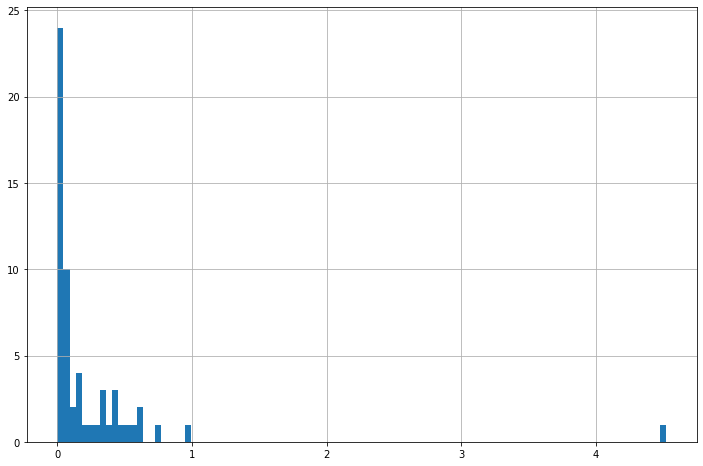

In [213]:
surface_noise_numbers(df_vegetation)

#### Glacier

Numer of grid points: 1057
Median variance: 0.07401303946971893
Mean variance: 0.16656251
Median median error: 4.473470687866211
Mean mean error: 4.665841


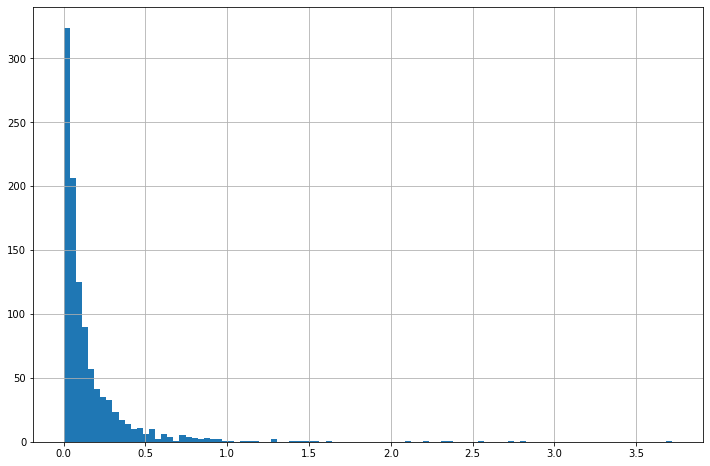

In [210]:
df_glacier = df_cat.query('si10Fr_change_is_significant')
surface_noise_numbers(df_glacier)

#### Deep dive on individual bad points

In [211]:
lake_natron = df_lake.query('latitude_ERA == -2.3887580539270044 & longitude_ERA == 36.0000')
lake_natron_northern_edge =df_lake.query('latitude_ERA == -2.10772769472398 & longitude_ERA == 36.0000') 
lake_blanche =df_lake.query('latitude_ERA ==  -29.367671674745356 & longitude_ERA == 139.6875') 
salt_lake_city =df_lake.query('latitude_ERA ==  41.17094491970063 & longitude_ERA ==  -113.39999999999998') 
farah_province =df_lake.query('latitude_ERA ==  31.615914311651938 & longitude_ERA == 61.120000000000005') 
gujarat_province =df_lake.query('latitude_ERA ==  24.028095261448925 & longitude_ERA ==  69.0') 
toshka_lakes =df_lake.query('latitude_ERA ==  23.18500423251539 & longitude_ERA ==  30.900000000000006') 
all_northern_canada_points = df_lake.query('50.0 < latitude_ERA & -130 < longitude_ERA < -80')

caspain_1 = df_lake.query('latitude_ERA ==  46.22948997297545 & longitude_ERA ==   49.125')
caspain_2 = df_lake.query('latitude_ERA ==  46.22948997297545 & longitude_ERA ==    49.5')
caspain_3 = df_lake.query('latitude_ERA ==  46.51052023808231 & longitude_ERA ==    49.5')
caspain_4 = df_lake.query('latitude_ERA ==  47.072580762649004 & longitude_ERA ==    51.599999999999994')

caspian_edge = pd.concat([caspain_1,caspain_2,caspain_3,caspain_4])

bering_glacier = df_glacier.query('latitude_ERA == 60.280999861571715   & longitude_ERA ==    -143.4666666666667')
juncal_glacier = df_glacier.query('latitude_ERA == -33.021065936911214   & longitude_ERA ==    -70.07999999999998')


In [186]:
selected_dfs = dict({'lake_natron':lake_natron,
                     'lake_natron_northern_edge':lake_natron_northern_edge,
                     'lake_blanche':lake_blanche,
                     'salt_lake_city':salt_lake_city,
                     'farah_province':farah_province,
                     'gujarat_province':gujarat_province,
                     'toshka_lakes':toshka_lakes,
                     'all_northern_canada_points':all_northern_canada_points,
                     'caspian_edge':caspian_edge,
                     'bering_glacier':bering_glacier,
                     'juncal_glacier':juncal_glacier})

lake_natron
Numer of grid points: 1
Median: 0.019072890281677246
Mean: 0.01907289
************************
lake_natron_northern_edge
Numer of grid points: 1
Median: 0.022181862965226173
Mean: 0.022181863
************************
lake_blanche
Numer of grid points: 1
Median: 0.9169919490814209
Mean: 0.91699195
************************
salt_lake_city
Numer of grid points: 1
Median: 0.0896233394742012
Mean: 0.08962334
************************
farah_province
Numer of grid points: 1
Median: 0.0002551457437220961
Mean: 0.00025514574
************************
gujarat_province
Numer of grid points: 1
Median: 8.630967140197754
Mean: 8.630967
************************
toshka_lakes
Numer of grid points: 1
Median: 1.1083770990371704
Mean: 1.1083771
************************
all_northern_canada_points
Numer of grid points: 756
Median: 0.005416114814579487
Mean: 0.007971809
************************
caspian_edge
Numer of grid points: 4
Median: 0.04191146418452263
Mean: 0.03920798
************************

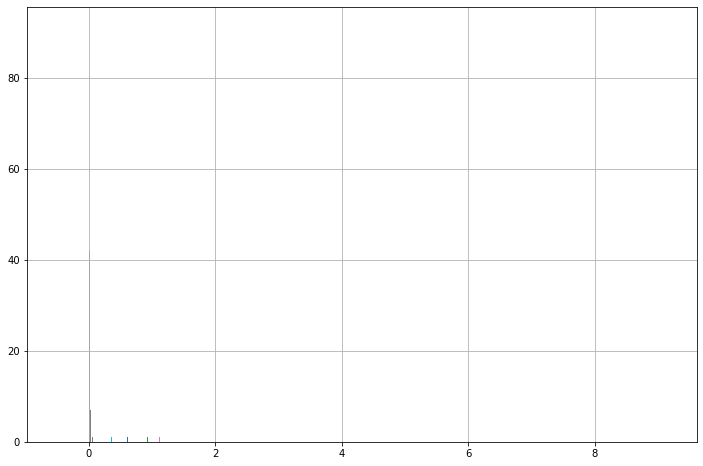

In [187]:
for key,value in selected_dfs.items():
    print(key)
    surface_noise_numbers(value)
    print("************************")

In [193]:
toshka_lakes[['MODIS_LST', 'prediction_1','prediction_2','prediction_3','prediction_4']]

,MODIS_LST,prediction_1,prediction_2,prediction_3,prediction_4
70081,318.107666,316.439697,314.425262,316.792664,313.698792


In [196]:
gujarat_province[['MODIS_LST', 'prediction_1','prediction_2','prediction_3','prediction_4']]

,MODIS_LST,prediction_1,prediction_2,prediction_3,prediction_4
71526,313.741486,309.216736,309.648285,302.657593,309.395355


In [195]:
gujarat_province

,latitude_ERA,longitude_ERA,MODIS_LST,prediction_error_1,prediction_1,prediction_error_2,prediction_2,prediction_error_3,prediction_3,prediction_error_4,...,changeAbs_V20V15_z,clFr_change_is_significant,cvhFr_change_is_significant,cvlFr_change_is_significant,oceanFr_change_is_significant,si10Fr_change_is_significant,dl_change_is_significant,z_change_is_significant,bitstring,variance
71526,24.028095,69.0,313.741486,5.290875,309.216736,5.206067,309.648285,11.188568,302.657593,5.452314,...,0.267944,True,False,False,False,False,True,True,1001001,8.630967


In [190]:
gujarat_province

,latitude_ERA,longitude_ERA,MODIS_LST,prediction_error_1,prediction_1,prediction_error_2,prediction_2,prediction_error_3,prediction_3,prediction_error_4,...,changeAbs_V20V15_z,clFr_change_is_significant,cvhFr_change_is_significant,cvlFr_change_is_significant,oceanFr_change_is_significant,si10Fr_change_is_significant,dl_change_is_significant,z_change_is_significant,bitstring,variance
71526,24.028095,69.0,313.741486,5.290875,309.216736,5.206067,309.648285,11.188568,302.657593,5.452314,...,0.267944,True,False,False,False,False,True,True,1001001,8.630967


In [146]:
juncal_glacier['longitude_ERA'].to_numpy()[0]

-70.07999999999998

In [199]:
juncal_glacier

,latitude_ERA,longitude_ERA,MODIS_LST,prediction_error_1,prediction_1,prediction_error_2,prediction_2,prediction_error_3,prediction_3,prediction_error_4,...,changeAbs_V20V15_z,clFr_change_is_significant,cvhFr_change_is_significant,cvlFr_change_is_significant,oceanFr_change_is_significant,si10Fr_change_is_significant,dl_change_is_significant,z_change_is_significant,bitstring,variance
6228,-33.021066,-70.08,290.502838,4.377077,289.279449,3.396034,289.043396,3.773364,289.165131,5.182201,...,0.957031,False,False,False,False,True,True,False,0001010,0.607728
